In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import coordinates as coord
from astropy import constants, cosmology, units

import colddust_sed_models

from IPython.display import display, Math

In [2]:
#Insert here the redshift of the source. The unities to be used 
#are specified next to each quantity. Cosmology used is from Planck2018

z = 6.4386 
cosmop = cosmology.FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.726) 

D_l = cosmop.luminosity_distance(z).to('kpc').value #kpc
scale = cosmop.kpc_proper_per_arcmin(z).to('kpc/arcsec').value #kpc/"
c = constants.c.value #m/s
Msun = constants.M_sun.value #kg

print(D_l, c, scale, Msun)

63970075.04301593 299792458.0 5.604918673848694 1.988409870698051e+30


In [3]:
#Insert the area of the galaxy in kpc^2. Here, for instance, I put the FWHM sizes in arcsec^2

A = np.array([0.367*0.316,0.355*0.306])*np.pi*scale**2/4 #kpc^2
A = np.mean(A)

#Insert the observed frequency of your observations in GHz. If you want to put the rest-frame frequencies, 
#just adapt the code accordingly, leaving the mae of the variables unchanged

nu_obs = np.array([103.4014,239.2784,247.4335,248.4906,286.8863,325.7194,343.5505,462.8249]) #GHz
nu =  nu_obs*(1+z) #rest frame frequency, GHz
wave_obs = c*1e6/(nu_obs*1e9) #micrometer

#Insert the flux densities correspoding to the observed frequecies above in mJy and thei errors

flux = np.array([0.263,4.313,4.947,4.105,6.622,9.374,7.112,15.46]) #mJy 
err1 = np.array([0.033,0.041,0.062,0.086,0.084,0.086,0.043,0.33])  #mJy

#This is just for taking into account the calibration uncertainties that are added in quadrature 
# to err1 above. If this is not needed, comment the following two lines and rename the above err1 as flux_err

quad1 = np.array([0.02,0.06,0.07,0.07,0.07,0.08,0.09,0.1])
flux_err = np.sqrt(err1**2+(flux*quad1)**2)

# Set the values of fixed paramters according to your needs. Below are some examples.

#fix_par = [2.1,40] #values of fixed parameters if you need to fix [beta, Tdust] --> log(Mdust/Msun) free
#fix_par = [40] #if you need to fix Tdust only --> log(Mdust/Msun), beta free
fix_par = 0 #if you do not need to fix any paramter --> --> log(Mdust/Msun), beta, Tdust free 

#Set the values for the starting position of the chain. It can be randomised.

#start_pos = [8.] #example for [log10(Mdust/Msun)] 
#start_pos = [8.,1.5] #example for [log10(Mdust/Msun), beta] 
start_pos = [8.,1.5, 60.0] #example for [log10(Mdust/Msun), beta, Tdust] 

#Set number of free paramters. It can be 1 or 2 or 3.

ndim = 3 

In [4]:
#Here the chain is runned or imported (if previously runned)
#Always remember to remove the file .h5 if you want to run twice the same chain.

filename = 'j183-sed-MCMC.h5' #change the filename as you wish. Here the chain will be saved

#For additional inputs in run_chain() see Readme.md
sampler = colddust_sed_models.sed_models.run_chain(start_pos, ndim,filename,nu_obs,\
                                                   flux,flux_err,z,D_l,A,fix_par) 
print('Chain done')

Chain done


In [5]:
#Print the best-fitting values

#popt = best-fitting [log(Mdust/Msun), beta, Tdust] in case ndim=3
#q = down and up error for popt
#mdust = [Mdust, err_down_Mdust, err_up_Mdust]

popt, q, mdust = colddust_sed_models.results_plot.sed_results(sampler, ndim, dis=250)

label_new = ["\log(M_{dust}/M_\odot)", r"\beta",r"T_{dust}"] 
j = 0
for i in range(ndim):
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt2 = txt.format(popt[i], q[j], q[j+1], label_new[i])
    display(Math(txt2))
    j = j+2

print('M_dust/M_sun = %.2E - %.2E + %.2E' %(mdust[0], mdust[1], mdust[2]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

M_dust/M_sun = 3.87E+08 - 9.76E+07 + 8.63E+07


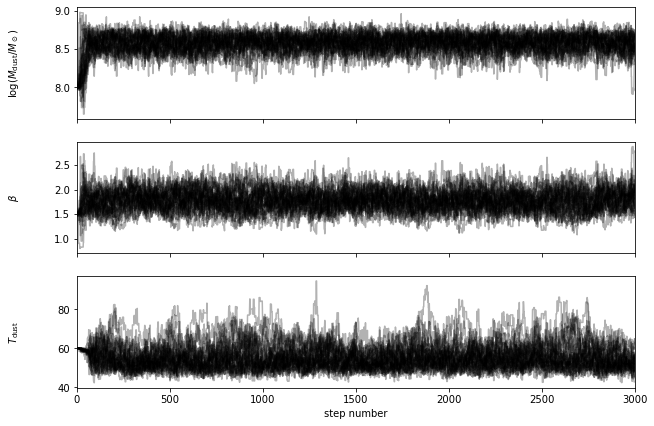

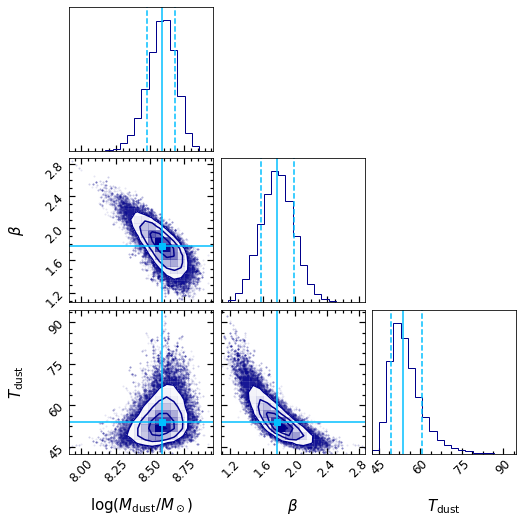

In [6]:
#Plot the chains and the corner plot

name = 'J183'
colddust_sed_models.results_plot.sed_res_plot(sampler, ndim, name)

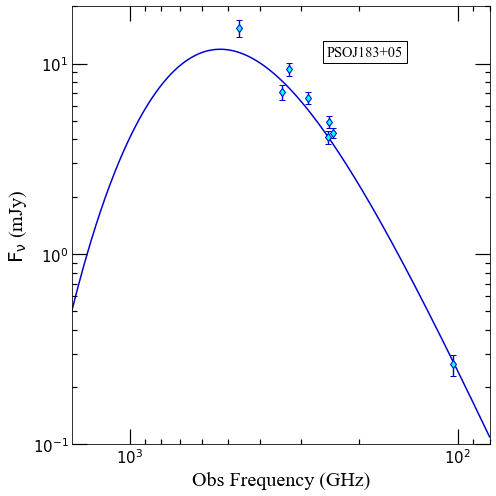

In [7]:
#Plot SED

freq_plot = np.arange(80,4000) #GHz
name = 'PSOJ183+05'

ylim = [1e-1, 20]
xlim = [80,1500]
pos_text = [250,11]

colddust_sed_models.results_plot.plot_sed(freq_plot,sampler,nu_obs,flux,flux_err,z,D_l,A,c,fix_par,\
                                          ndim,ylim,xlim,pos_text,name)